In [44]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,PolynomialFeatures,normalize ,LabelEncoder
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold, GridSearchCV , train_test_split
from sklearn.linear_model import LogisticRegression , Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv("dados/transformado.csv", sep=",")

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   partida_id                 1876 non-null   int64  
 1   rodada                     1876 non-null   int64  
 2   mandante                   1876 non-null   object 
 3   visitante                  1876 non-null   object 
 4   formacao_mandante          1876 non-null   object 
 5   formacao_visitante         1876 non-null   object 
 6   vencedor                   1876 non-null   object 
 7   mandante_placar            1876 non-null   int64  
 8   visitante_placar           1876 non-null   int64  
 9   chutes_mandante            1876 non-null   int64  
 10  chutes_no_alvo_mandante    1876 non-null   int64  
 11  posse_de_bola_mandante     1876 non-null   float64
 12  passes_mandante            1876 non-null   int64  
 13  precisao_passes_mandante   1876 non-null   float

In [47]:
#union formacao mandante com formacao visitante
dt = pd.concat([df['formacao_mandante'],df['formacao_visitante']])

dt.unique()

array(['4-2-3-1', '4-3-3', '4-1-4-1', '4-2-4-0', '3-4-2-1', '3-4-1-2',
       '3-4-3', '5-4-1', '4-3-2-1', '4-4-2', '4-5-1', '4-2-2-2',
       '3-1-4-2', '4-1-3-2', '5-3-2', '4-4-1-1', '4-3-1-2', '3-2-4-1',
       '4-1-2-1-2', '3-5-2', '3-5-1-1'], dtype=object)

In [48]:
#union mandante com visitante
mv = pd.concat([df['mandante'],df['visitante']])

mv.unique()

array(['Cruzeiro', 'Vitoria', 'Santos', 'America-MG', 'Vasco',
       'Internacional', 'Corinthians', 'Athletico-PR', 'Sao Paulo',
       'Botafogo-RJ', 'Bahia', 'Flamengo', 'Parana', 'Ceara',
       'Atletico-MG', 'Fluminense', 'Chapecoense', 'Palmeiras', 'Gremio',
       'Sport', 'Avai', 'Goias', 'Fortaleza', 'CSA', 'Coritiba',
       'Bragantino', 'Atletico-GO', 'Cuiaba', 'Juventude'], dtype=object)

In [49]:
#transformando as dados categoricos como Formação, Mandante, Visitante em dados numericos
le = LabelEncoder()
le.fit(dt)
df['formacao_mandante'] = le.transform(df["formacao_mandante"])
df['formacao_visitante'] = le.transform(df["formacao_visitante"])

le.fit(mv)
df['mandante'] = le.transform(df["mandante"])
df['visitante'] = le.transform(df["visitante"])

In [50]:
#amostragem depois da transformação
df[['formacao_mandante','formacao_visitante','mandante','visitante']].tail()

,formacao_mandante,formacao_visitante,mandante,visitante
1871,9,9,14,12
1872,11,11,7,16
1873,9,11,11,3
1874,11,11,20,22
1875,11,7,18,25


In [51]:
#retirando a coluna vencedor que é do tipo categorica e vamos utilizar a columa resultado.
df.drop(columns=['vencedor','rodada','total_gols'],inplace=True)

In [52]:
#criando dataset auxiliar
df_aux = pd.DataFrame(df[(df['temporada']==2022)])

# Eliminando os dados de df_aux do df_model
df_model = df.drop(index = df_aux.index)

#arrumando index de df_aux
df_aux.reset_index(inplace = True)
df_aux.drop('index', axis = 1, inplace = True)

In [53]:
print("-----------------------------------")
print("* SHAPE DOS MODELOS")
print ("O dataset DF_MODEL será utilizado para TESTE, ele contêm {} Linhas  e  {} Colunas : ".format( df_model.shape[0] , df_model.shape[1]))
print ("O dataset DF_AUX será utilizado para VALIDAÇÃO do TESTE E TREINO, ele contem {} Linhas  e  {} Colunas : ".format( df_aux.shape[0] , df_aux.shape[1]))
print(" ")
print("-----------------------------------")
print("* TEMPORADAS DO MODELO ")
print("Temporada Modelo", df_model.temporada.unique(), " Qtd linhas x colunas", df_model.shape)
print("Temporada Auxiliar" , df_aux.temporada.unique() , " Qtd linhas x colunas",df_aux.shape)

-----------------------------------
* SHAPE DOS MODELOS
O dataset DF_MODEL será utilizado para TESTE, ele contêm 1496 Linhas  e  30 Colunas : 
O dataset DF_AUX será utilizado para VALIDAÇÃO do TESTE E TREINO, ele contem 380 Linhas  e  30 Colunas : 
 
-----------------------------------
* TEMPORADAS DO MODELO 
Temporada Modelo [2018 2019 2020 2021]  Qtd linhas x colunas (1496, 30)
Temporada Auxiliar [2022]  Qtd linhas x colunas (380, 30)


In [54]:
#separar features e label
label_model = df[(df['temporada'] <= 2021)]['resultado']
label_aux = df[(df['temporada'] == 2022)]['resultado']

features_model = df[(df['temporada'] <= 2021)]
features_aux = df[(df['temporada'] == 2022)]

features_model = features_model.drop(columns=['resultado'])
features_aux = features_aux.drop(columns=['resultado'])

In [55]:
#Devido as diferenças numericas entre os dados, vamos normaliza-los.
scaler = MinMaxScaler().fit(features_model)
features_scale_model = scaler.transform(features_model)
features_scale_aux = scaler.transform(features_aux)

print(features_scale_aux)

[[1.00065833 0.57142857 0.85714286 ... 0.5        0.05555556 1.33333333]
 [1.00131666 0.07142857 0.53571429 ... 0.25       0.55555556 1.33333333]
 [1.00197498 0.78571429 0.32142857 ... 0.         0.44444444 1.33333333]
 ...
 [1.24884793 0.39285714 0.10714286 ... 0.         0.22222222 1.33333333]
 [1.24950625 0.71428571 0.78571429 ... 0.25       0.27777778 1.33333333]
 [1.25016458 0.64285714 0.89285714 ... 0.         0.22222222 1.33333333]]


## Machine Learning

In [56]:
# Separando os dados de Treino e Teste, com 20% para testes, lembrando que o df_aux só será utilizando para validação do ML
SEED = 23
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(features_scale_model, label_model, test_size = 0.20, stratify = label_model )
print('O dataset de treino possui {} linhas e o de teste {} linhas.'.format(X_train.shape[0], X_test.shape[0]))

O dataset de treino possui 1196 linhas e o de teste 300 linhas.


In [57]:
#LogisticRegression(multi_class='multinomial',max_iter=2000)
model_logr = LogisticRegression(multi_class='multinomial',max_iter=2000)
model_logr.fit(X_train,y_train)
pred= model_logr.predict(X_test)
target_names = ['Vitoria Mandante', 'Vitoria Visitante', 'Empate']
print('* MODELO {} '.format(model_logr))
print(" ")
print(classification_report(y_test,pred,target_names=target_names,digits=4))
print(" ")
print(" ")

* MODELO LogisticRegression(max_iter=2000, multi_class='multinomial') 
 
                   precision    recall  f1-score   support

 Vitoria Mandante     0.9732    1.0000    0.9864       145
Vitoria Visitante     0.9692    0.9000    0.9333        70
           Empate     0.9186    0.9294    0.9240        85

         accuracy                         0.9567       300
        macro avg     0.9537    0.9431    0.9479       300
     weighted avg     0.9568    0.9567    0.9563       300

 
 


In [58]:
#SVC(kernel='linear', C=2, decision_function_shape='ovr')
model_svc = SVC(kernel='linear', C=2, decision_function_shape='ovr')
model_svc.fit(X_train,y_train)
pred= model_svc.predict(X_test)
target_names = ['Vitoria Mandante', 'Vitoria Visitante', 'Empate']
print('* MODELO {} '.format(model_svc))
print(" ")
print(classification_report(y_test,pred,target_names=target_names,digits=4))
print(" ")
print(" ")

* MODELO SVC(C=2, kernel='linear') 
 
                   precision    recall  f1-score   support

 Vitoria Mandante     1.0000    1.0000    1.0000       145
Vitoria Visitante     1.0000    1.0000    1.0000        70
           Empate     1.0000    1.0000    1.0000        85

         accuracy                         1.0000       300
        macro avg     1.0000    1.0000    1.0000       300
     weighted avg     1.0000    1.0000    1.0000       300

 
 


In [69]:
#DecisionTreeClassifier(max_depth=4)
model_dtc = DecisionTreeClassifier(max_depth=4)
model_dtc.fit(X_train,y_train)
pred= model_dtc.predict(X_test)
target_names = ['Vitoria Mandante', 'Vitoria Visitante', 'Empate']
print('* MODELO {} '.format(model_dtc))
print(" ")
print(classification_report(y_test,pred,target_names=target_names,digits=4))
print(" ")
print(" ")

* MODELO DecisionTreeClassifier(max_depth=4) 
 
                   precision    recall  f1-score   support

 Vitoria Mandante     1.0000    0.9931    0.9965       145
Vitoria Visitante     0.9333    1.0000    0.9655        70
           Empate     1.0000    0.9529    0.9759        85

         accuracy                         0.9833       300
        macro avg     0.9778    0.9820    0.9793       300
     weighted avg     0.9844    0.9833    0.9835       300

 
 


In [71]:
#RandomForestClassifier(n_estimators=100)
model_rand = RandomForestClassifier(n_estimators=100)
model_rand.fit(X_train,y_train)
pred= model_rand.predict(X_test)
target_names = ['Vitoria Mandante', 'Vitoria Visitante', 'Empate']
print('* MODELO {} '.format(model_rand))
print(" ")
print(classification_report(y_test,pred,target_names=target_names,digits=4))
print(" ")
print(" ")

* MODELO RandomForestClassifier() 
 
                   precision    recall  f1-score   support

 Vitoria Mandante     0.9412    0.9931    0.9664       145
Vitoria Visitante     1.0000    0.9714    0.9855        70
           Empate     0.9620    0.8941    0.9268        85

         accuracy                         0.9600       300
        macro avg     0.9677    0.9529    0.9596       300
     weighted avg     0.9608    0.9600    0.9597       300

 
 


In [61]:
#armazenando em um array os modelos escolidos
models = [model_logr,model_svc,model_dtc,model_rand]

In [75]:
SEED = 42
np.random.seed(SEED)

#Divide o conjunto de dados em k dobras, permitindo que cada parte do conjunto de dados seja usada para teste e treinamento em diferentes momentos.
cv = StratifiedKFold(n_splits = 5, shuffle = True)

print("******* CROSS VALIDATION SCORE ******* ")
print(" ")
for model in models:
    results = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'accuracy')
    results2 = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'precision_macro')
    results3 = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'recall_macro')
    results4 = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'f1_macro')
    
    mean = results.mean()
    dv = results.std()
    mean2 = results2.mean()
    dv2 = results2.std()
    mean3 = results3.mean()
    dv3 = results3.std()
    mean4 = results4.mean()
    dv4 = results4.std()
    print("==========================================")
    print("### Modelo: {}".format(model))
    print(" ")
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
    print(" ")
    print('Precisão média: {:.2f}%'.format(mean2*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'.format((mean2 - 2*dv2)*100, (mean2 + 2*dv2)*100))
    print(" ")
    print('Recall média: {:.2f}%'.format(mean3*100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'.format((mean3 - 2*dv3)*100, (mean3 + 2*dv3)*100))
    print(" ")
    print('F1-score média: {:.2f}%'.format(mean4*100))
    print('Intervalo de F1-score: [{:.2f}% ~ {:.2f}%]'.format((mean4 - 2*dv4)*100, (mean4 + 2*dv4)*100))
    print(" ")
    print(" ")


******* CROSS VALIDATION  ******* 
 
### Modelo: LogisticRegression(max_iter=2000, multi_class='multinomial')
 
Acurácia média: 93.73%
Intervalo de acurácia: [90.68% ~ 96.78%]
 
Precisão média: 94.05%
Intervalo de Precisão: [90.25% ~ 97.86%]
 
Recall média: 91.46%
Intervalo de Recall: [88.85% ~ 94.07%]
 
F1-score média: 92.61%
Intervalo de F1-score: [90.18% ~ 95.03%]
 
 
### Modelo: SVC(C=2, kernel='linear')
 
Acurácia média: 100.00%
Intervalo de acurácia: [100.00% ~ 100.00%]
 
Precisão média: 100.00%
Intervalo de Precisão: [100.00% ~ 100.00%]
 
Recall média: 100.00%
Intervalo de Recall: [100.00% ~ 100.00%]
 
F1-score média: 100.00%
Intervalo de F1-score: [100.00% ~ 100.00%]
 
 
### Modelo: DecisionTreeClassifier(max_depth=4)
 
Acurácia média: 99.00%
Intervalo de acurácia: [97.86% ~ 100.13%]
 
Precisão média: 98.68%
Intervalo de Precisão: [97.44% ~ 99.91%]
 
Recall média: 98.14%
Intervalo de Recall: [95.61% ~ 100.66%]
 
F1-score média: 98.61%
Intervalo de F1-score: [97.64% ~ 99.58%]
 


In [79]:
#Validação com dados nunca vistos
SEED = 23
np.random.seed(SEED)

X_pred = features_scale_aux
y_pred = label_aux


pred_final=model_svc.predict(X_pred)

svc_acc = accuracy_score(y_pred, pred_final)
print("======= VALIDAÇÃO =======")
print(" ")
print('MODELO {} '.format(model_svc))
print(" ")
print(classification_report(y_pred,pred_final,digits=4))
print(" ")
print(" ")

======= VALIDAÇÃO =======
 
MODELO SVC(C=2, kernel='linear') 
 
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       168
           2     1.0000    1.0000    1.0000       104
           3     1.0000    1.0000    1.0000       108

    accuracy                         1.0000       380
   macro avg     1.0000    1.0000    1.0000       380
weighted avg     1.0000    1.0000    1.0000       380

 
 


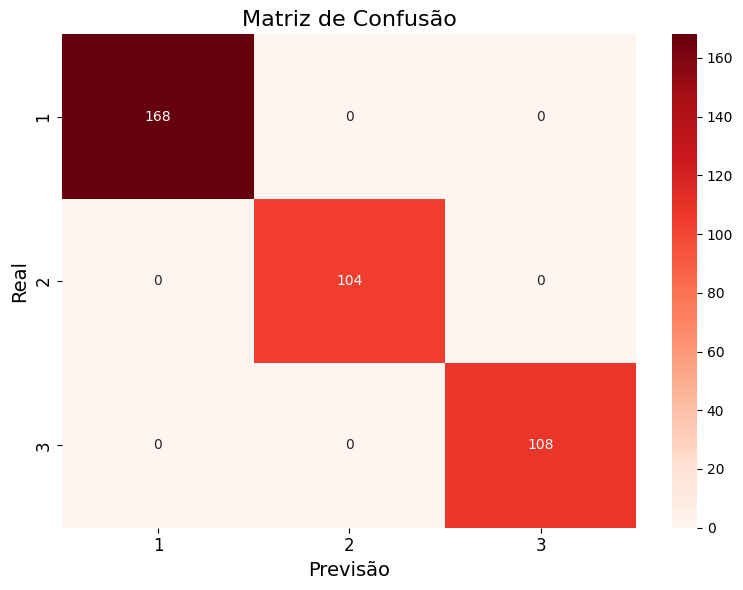

In [80]:
cf_matrix=pd.crosstab(y_pred, pred_final, rownames=['real'] , colnames=['previsao'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Reds', cbar=True, ax=ax)
ax.set_title('Matriz de Confusão', fontsize=16)
ax.set_xlabel('Previsão', fontsize=14)
ax.set_ylabel('Real', fontsize=14)
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [68]:
df=pd.DataFrame({'real': y_pred, 'previsao':pred_final, 'partida_id':features_aux['partida_id']})

print(df)


      real  previsao  partida_id
1496     3         3        7646
1497     3         3        7647
1498     2         2        7648
1499     1         1        7649
1500     2         2        7650
...    ...       ...         ...
1871     1         1        8021
1872     2         2        8022
1873     2         2        8023
1874     1         1        8024
1875     2         2        8025

[380 rows x 3 columns]
